# Принятие решений в бизнесе на основе данных. Приоритезация гипотез. A/B тест.

# Задача :

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

# Описание данных

Данные для первой части :


Файл /datasets/hypothesis.csv.

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 
Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части :


Файл /datasets/orders.csv.

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 

date — дата;
group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Предобработка данных.

In [1]:
# Импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
# приведем названия столбцов к нижнему регистру
hypothesis.columns = map(str.lower, hypothesis.columns)
hypothesis.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
#поменяем тип даты на datetime
orders['date'] = orders['date'].astype('datetime64[D]')
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
#поменяем тип даты на datetime
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
# проверка дубликатов
print('Кол-во дубликатов в таблице hypothesis:',hypothesis.duplicated().sum())
print('Кол-во дубликатов в таблице orders:',orders.duplicated().sum())
print('Кол-во дубликатов в таблице visitors:',visitors.duplicated().sum())

Кол-во дубликатов в таблице hypothesis: 0
Кол-во дубликатов в таблице orders: 0
Кол-во дубликатов в таблице visitors: 0


Предобработка завершена, пропущенных значений и дубликатов нет, типы данных корректны.

In [6]:
# добавим информацию о группах и датах
print('Группы в АВ-тесте в датафреймах :', visitors['group'].unique())
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))

Группы в АВ-тесте в датафреймах : ['A' 'B']
Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916

Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



##  Приоритизация гипотез.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))
pd.options.display.max_colwidth = 100

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [8]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Text(0, 0.5, 'ICE')

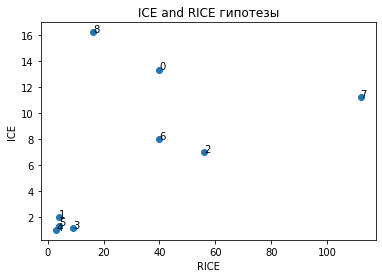

In [9]:
y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")

### Вывод
По фреймворку ICE самые значимые гипотезы 8,0 и 7. После применения RICE значимые позиции изменились на гипотезы 7,2 и 0.

Это произошло так как при использовании фреймворка ICE в отличие от RICE мы не учитывали охват пользователей, хотя это является для нас важной составляющей.

Итог : наиболее приоритетными гипотезами будут 7, 2, 0.

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам. 

In [10]:
orders.head(3)
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


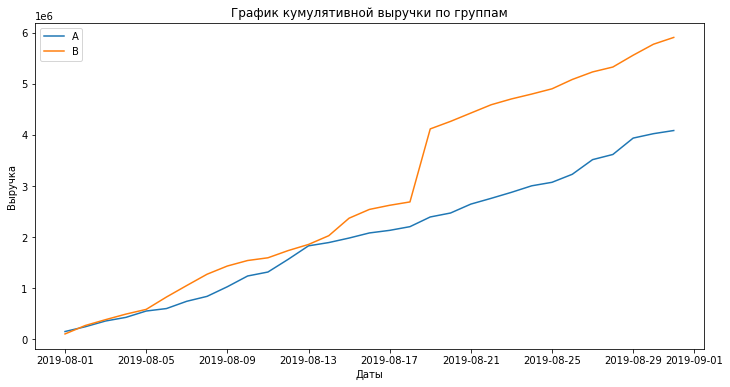

In [11]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title("График кумулятивной выручки по группам") 
plt.xlabel("Даты") 
plt.ylabel("Выручка");

In [12]:
print('Минимальная дата привлечения пользователей:',cumulativeData['date'].min())
print('Максимальная дата привлечения пользователей:',cumulativeData['date'].max())

Минимальная дата привлечения пользователей: 2019-08-01 00:00:00
Максимальная дата привлечения пользователей: 2019-08-31 00:00:00


Датафрейм cummulativeData был создан корректно, минимальная и максимальная даты в этом датафрейме совпадают с минимальной и максимальной датой в исходных данных.

Вывод : исходя из графика, группа B стабильно приносит большую выручку чем группа A.

### Построим график кумулятивного среднего чека по группам. 

Text(0, 0.5, 'Средний чек')

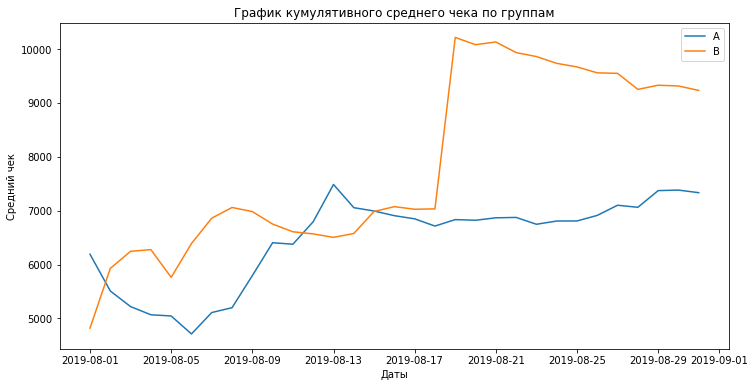

In [13]:
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title("График кумулятивного среднего чека по группам") 
plt.xlabel("Даты") 
plt.ylabel("Средний чек")

Вывод : Средний чек у обеих групп в первой половине графика скачет, ближе к концу становится более равномерным. У группы В средний чек выше, однако произошел резкий скачок 18.08.2019, возможно есть выбросы, которые повлияли на это.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

Text(0, 0.5, 'Изменение среднего чека группы В к группе А')

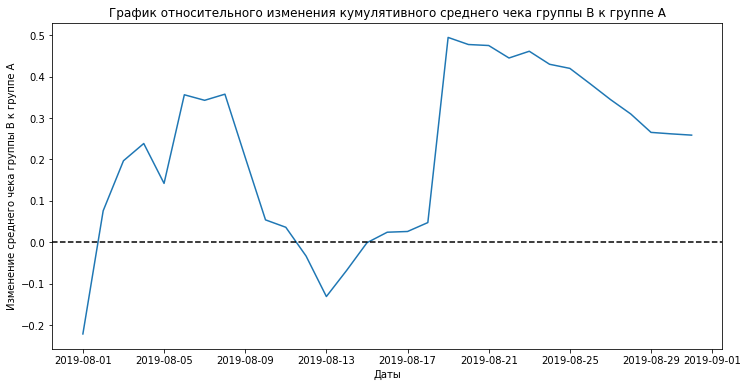

In [14]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A") 
plt.xlabel("Даты") 
plt.ylabel("Изменение среднего чека группы В к группе А")

Вывод : В нескольких точках график различия между сегментами резко «скачет», где-то есть аномалии. 

### Построим график кумулятивной конверсии по группам.

Text(0, 0.5, 'Конверсия')

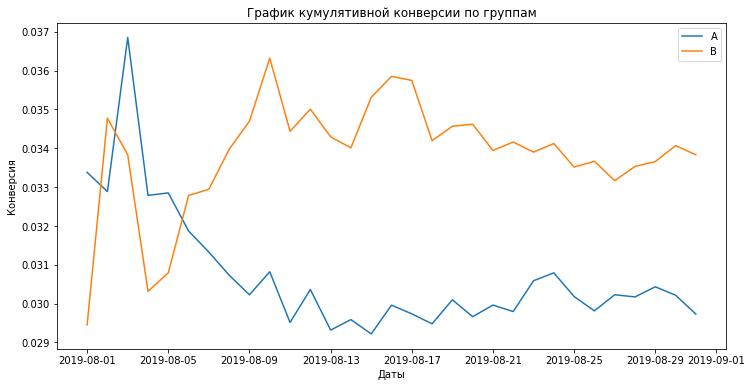

In [15]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(12,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title("График кумулятивной конверсии по группам") 
plt.xlabel("Даты") 
plt.ylabel("Конверсия")

Вывод : Конверсия группы В стабильно лучше конверсии группы А.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

Text(0, 0.5, 'Изменение конверсии группы B к группе A')

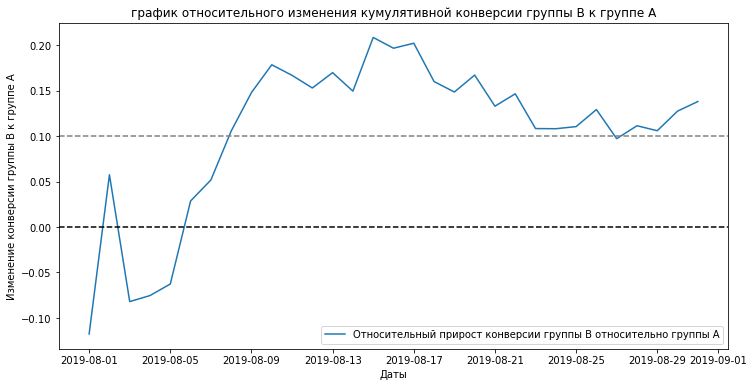

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title("график относительного изменения кумулятивной конверсии группы B к группе A") 
plt.xlabel("Даты") 
plt.ylabel("Изменение конверсии группы B к группе A")

Вывод : Конверсия группы В лучше конверсии группы А на 10%.

### Построим точечный график количества заказов по пользователям. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

[2. 4.]


Text(0, 0.5, 'Кол-во заказов')

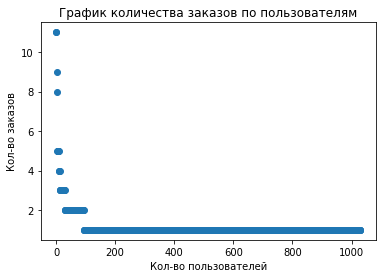

In [17]:
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
ordersByUsers.columns = ['visitorId', 'orders']
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
print(np.percentile(ordersByUsers['orders'], [95, 99])) 
plt.title("График количества заказов по пользователям") 
plt.xlabel("Кол-во пользователей") 
plt.ylabel("Кол-во заказов")


Вывод : исходя из графика и перцентлей только 5% пользователей совершают более 2 заказов. 
Возьмем 2 заказа за норму, больше-аномалия.

### Построим точечный график стоимостей заказов. Посчитаем 95-й и 99-й перцентили стоимости заказов.

[28000.  58233.2]


Text(0, 0.5, 'Стоимость заказов')

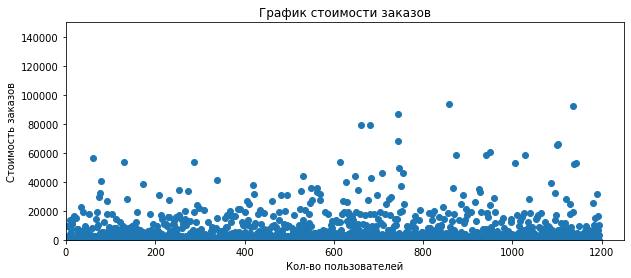

In [18]:
y_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,4))
plt.axis([0, 1250, 0, 150000])
plt.scatter(y_values, orders['revenue'])
print(np.percentile(orders['revenue'], [95, 99]))
plt.title("График стоимости заказов") 
plt.xlabel("Кол-во пользователей") 
plt.ylabel("Стоимость заказов")

Вывод : исходя из графика и перцентлей люди делают покупки в среднем на 20-25к, только 5% больше 28000. Возьмем 28000 за порог.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

In [19]:
# сделаем общую таблицу в разбивке на группы
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [20]:
# для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [21]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [22]:
print('P-value:',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост конверсии группы B по отношению к группе A:',"{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.01679
Относительный прирост конверсии группы B по отношению к группе A: 0.13808


Вывод: По «сырым» данным различия в конверсии групп A и B есть.

Первое число — 0,017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост конверсии группы B по отношению к группе A: 13,8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [23]:
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное изменение среднего чека группы B по отношению к группе A:''{0:.5f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.72929
Относительное изменение среднего чека группы B по отношению к группе A:0.25871


Вывод : По «сырым» данным различий в среднем чеке групп A и B нет.

Первое число — 0,729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Относительное изменение среднего чека группы B по отношению к группе A: 25,9%.


### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

In [24]:
#Узнаем, сколько всего аномальных пользователей 
# Помним, что приняли за норму 2 заказа и сумму покупки до 28000.
orders_max = np.percentile([ordersByUsersA['orders']], [95, 99])[0]


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_max]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_max]['userId'],
    ],
    axis=0,
)

revenu_max = np.percentile(orders['revenue'], [95, 99])[0]
usersWithExpensiveOrders = orders[orders['revenue'] > revenu_max]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Всего аномальных пользователей:',abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Всего аномальных пользователей: 74


In [25]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии группы B по отношению к группе A: ','{0:.5f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.01304
Относительный прирост конверсии группы B по отношению к группе A:  0.17270


Вывод: По «очищенным» данным различия в конверсии групп A и B есть.

Первое число — 0,013 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост конверсии группы B по отношению к группе A: 17,3%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [26]:
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное изменение среднего чека группы B по отношению к группе A: ',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.738
Относительное изменение среднего чека группы B по отношению к группе A:  -0.020


Вывод : По «очищенным» данным различий в среднем чеке A и B нет.

Первое число — 0,738 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Относительное изменение среднего чека группы B по отношению к группе A: -2%.
После очистки данных, средние чеки групп практически сравнялись.

## Вывод

Кумулятивные метрики по выручке, среднему чеку и конверсии выше в группе B.

Мы увидели резкие колебания на графике кумулятивного среднего чека в группе B до очистки данных от аномальных пользователей. Но после очистки разница между средними чеками стала минимальна.

До и после очистки данных, показатель конверсии в группе B больше показателя в группе A - на 14% до и на 17% после очистки данных. 

При проверки гипотез мы подтвердили, что данные по среднему чеку у групп не имеют значимых различий, а различия конверсии статистически значимы, что пользволяет нам сделать вывод о том, что мы можем остановить наш A/B тест и зафиксировать победу группы B.